In [1]:
import pandas as pd 

data = pd.read_pickle('train_preprocessed.pkl') #use with out dummy version (too big to load)

In [ ]:
customer_max_date = data.groupby('ncodpers').agg({'fecha_dato':max})
customer_data = pd.merge(data.reset_index(), customer_max_date, how='inner', left_on=['ncodpers', 'fecha_dato'], right_on=['ncodpers', 'fecha_dato']).set_index('index')

In [2]:
'''
seperate different type of columns

customer column: columns related with customers' info
history column: columns which customer experience product
dummy_column: columns need to change to dummy variable
bool_column: columns is true or false
linear_column: columns is linear data
del_column: columns need to be delete
'''

customer_column = list(data.columns)[:24]
history_columns = []

for k in data.columns:
    if 'history' in k:
        history_columns.append(k)


dummy_column = ['ind_empleado', 'sexo', 'indrel_1mes', 'nomprov', 'segmento', 'canal_entrada', 'pais_residencia']
bool_column = ['ind_nuevo', 'indrel', 'indresi', 'indext', 'conyuemp', 'indfall', 'tipodom']
linear_column = ['age', 'renta', 'antiguedad']
del_column = ['cod_prov', 'ind_actividad_cliente']

customer_data[history_columns] = customer_data[history_columns].astype(int)


In [5]:
#group by codprov to check there are 1-on-1
customer_data[['ncodpers', 'cod_prov', 'nomprov']].groupby(['cod_prov', 'nomprov']).count()

,,ncodpers
cod_prov,nomprov,
-1.0,NA,11049
1.0,ALAVA,2668
2.0,ALBACETE,7956
3.0,ALICANTE,22761
4.0,ALMERIA,4451
5.0,AVILA,2679
6.0,BADAJOZ,13191
7.0,"BALEARS, ILLES",9402
8.0,BARCELONA,90484


In [7]:
#replace few class labels to others

dummy_dist = {}
dummy_replace_label = {}

threshold = 0.1
for d in dummy_column:
    dummy_dist[d] = customer_data.groupby(d)['ncodpers'].count().sort_values(ascending=False)
    
    ratio_dist = dummy_dist[d] / sum(dummy_dist[d])
    
    
    replace_label_list = list(ratio_dist[ratio_dist < threshold].index)
    dummy_replace_label[d] = dict(zip(replace_label_list, ['other']*len(replace_label_list)))

In [8]:
#use replaced columns to save columns with replaced data (few class replaced with others)
dummy_replaced_column = []
for d in dummy_replace_label:
    customer_data[d+'_replaced'] = customer_data[d].replace(dummy_replace_label[d])
    dummy_replaced_column.append(d+'_replaced')

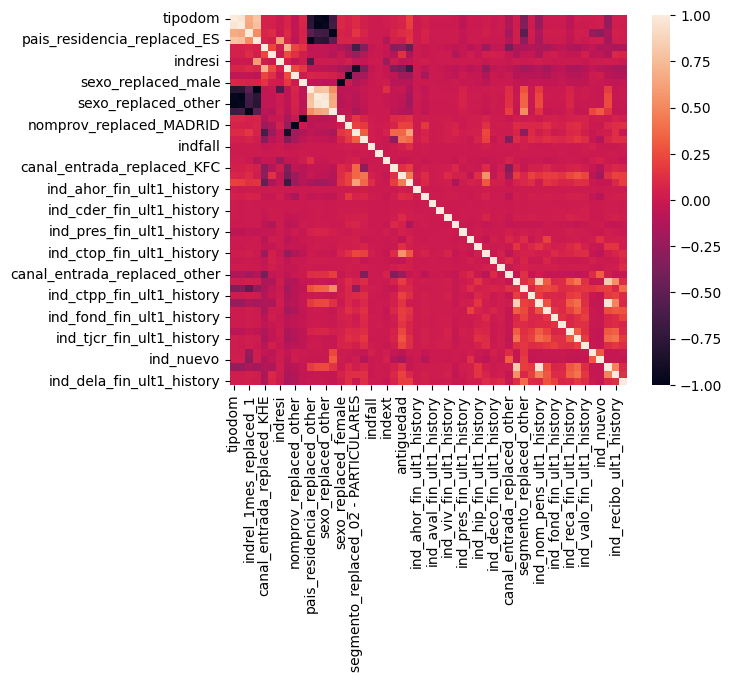

In [11]:
#draw heat map and sort by correlation matrix
import scipy
import seaborn as sns 

import numpy as np
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

cust_corr = pd.concat([customer_data[history_columns+linear_column+bool_column], pd.get_dummies(customer_data[dummy_replaced_column])], axis=1).corr()
sns.heatmap(cluster_corr(cust_corr))
cluster_corr(cust_corr).to_csv('corr_matrix_3.csv')


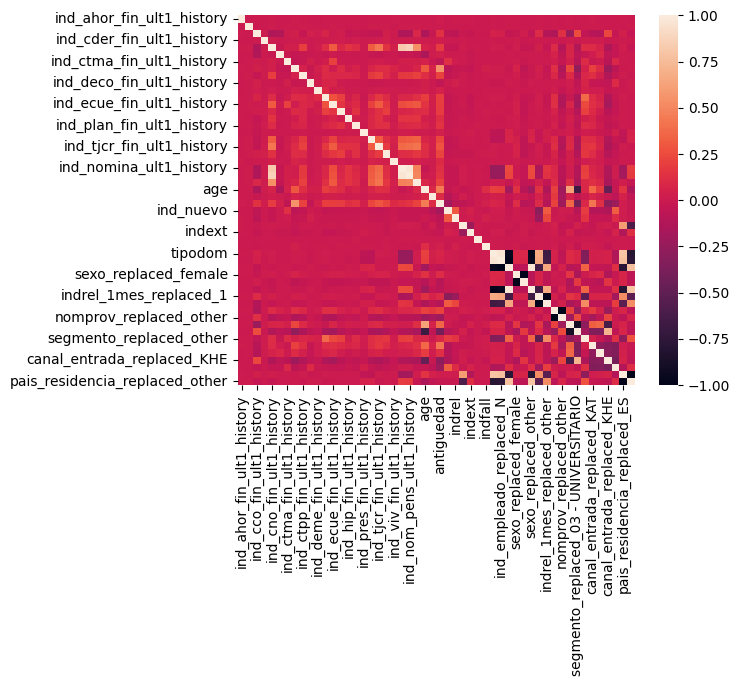

In [12]:
sns.heatmap(cust_corr)
cust_corr.to_csv('ori_corr_matrix.csv')

In [170]:
sor_corr = cust_corr.unstack().sort_values()
sor_corr = sor_corr[sor_corr<1]
sor_filt = sor_corr[sor_corr.abs() > 0.3]
sor_filt = sor_filt.iloc[range(0, len(sor_filt), 2)]
dummy_index = []
na_index = []
for index_1, index_2 in sor_filt.index:
    i1 = index_1.split('_')
    i2 = index_2.split('_')
    if i1[0] == i2[0]:
        dummy_index.append((index_1, index_2))
    elif 'NA' in i1 and 'NA' in i2:
        na_index.append((index_1, index_2))

sor_filt = sor_filt.drop(dummy_index).drop(na_index)
sor_filt.to_csv('corr_sort.csv')

In [176]:
#dummy_column = ['ind_empleado', 'sexo', 'indrel_1mes', 'nomprov', 'segmento','pais_residencia']

dummy_dist = {}

for d in dummy_replaced_column:
    dummy_dist[d] = customer_data.groupby(d)['ncodpers'].count().sort_values(ascending=False)
    
for d in bool_column:
    dummy_dist[d] = customer_data.groupby(d)['ncodpers'].count().sort_values(ascending=False)


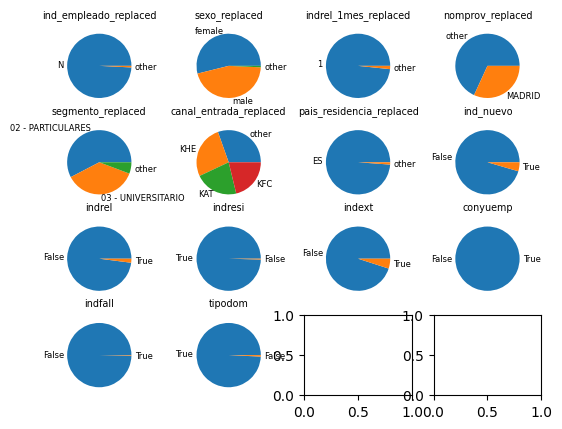

In [191]:
from matplotlib import pyplot as plt


import math 
fig_num = len(dummy_dist)
subplot_size = math.ceil(math.sqrt(fig_num))
subplot_width = math.ceil(fig_num / subplot_size)
fig, axs = plt.subplots(subplot_size, subplot_width)
cnt = 0

for c in dummy_dist:
    i = cnt // subplot_size
    j = cnt % subplot_width
    #plt.bar(dummy_dist[c].keys(), dummy_dist[c].values, width = 0.2)   
    #plt.pie(dummy_dist[c].values, labels=dummy_dist[c].keys())
    
    #plt.xlabel(c)
    #plt.ylabel('customer numbers')    
    #plt.show() 
    axs[i][j].pie(dummy_dist[c].values, labels=dummy_dist[c].keys(), textprops={'fontsize': 6})
    #axs[i][j].xlabel(c)
    axs[i][j].title.set_text(c)
    axs[i][j].title.set_fontsize('x-small')
    
    cnt += 1

In [14]:
#group by diffierent columns
age_cnt = customer_data.groupby('age')['ncodpers'].count()
sex_cnt = customer_data.groupby('sexo')['ncodpers'].count()
antiguedad_cnt = customer_data.groupby('antiguedad')['ncodpers'].count()
customer_income = customer_data.groupby('ncodpers')['renta'].max()
customer_income_dist = customer_income.groupby(pd.cut(customer_income, np.arange(0, 500000, 10000))).count()

In [23]:
age_cnt

age
-1      7031
 2        64
 3       116
 4       139
 5       189
        ... 
 115       1
 116       7
 117       2
 127       1
 164       1
Name: ncodpers, Length: 119, dtype: int64

(0.0, 100.0)

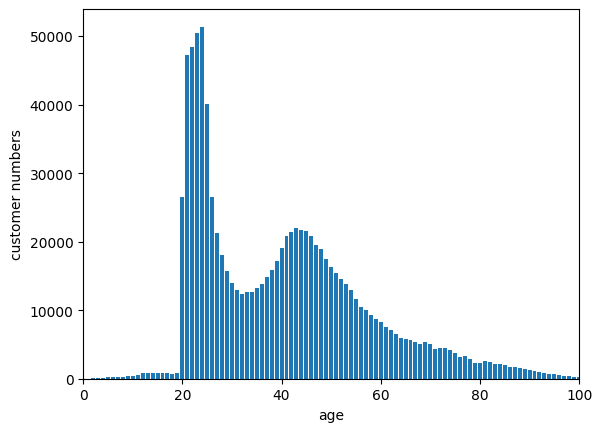

In [30]:
#plot customer age
plt.bar(age_cnt.index, age_cnt)
plt.xlabel('age')
plt.ylabel('customer numbers')
plt.xlim([0, 100])


Text(0, 0.5, 'customer numbers')

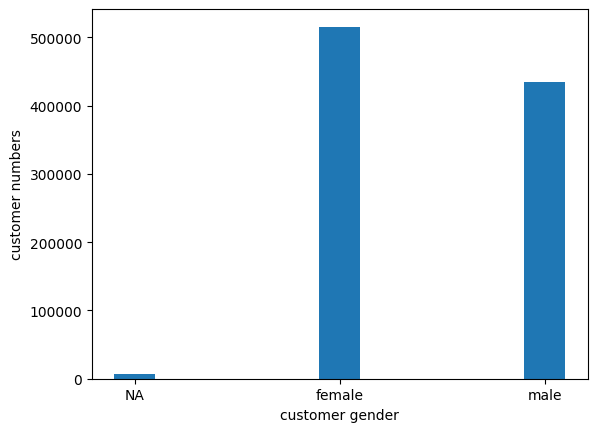

In [17]:
#plot customer's gender
plt.bar(sex_cnt.index, sex_cnt,  width = 0.2)
plt.xlabel('customer gender')
plt.ylabel('customer numbers')

Text(0, 0.5, 'customer numbers')

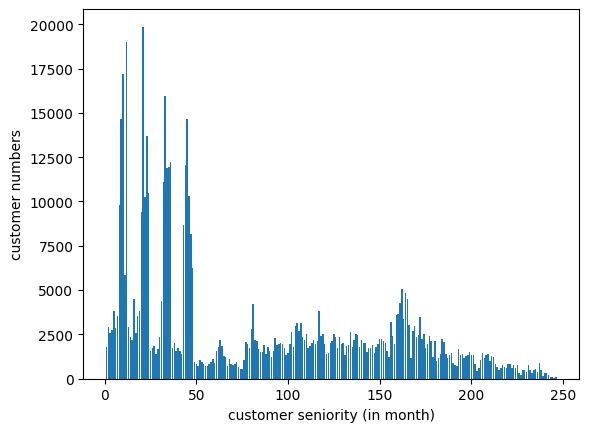

In [31]:
#customer seniority
plt.bar(antiguedad_cnt[antiguedad_cnt.index>0].index, antiguedad_cnt[antiguedad_cnt.index>0])
plt.xlabel('customer seniority (in month)')
plt.ylabel('customer numbers')




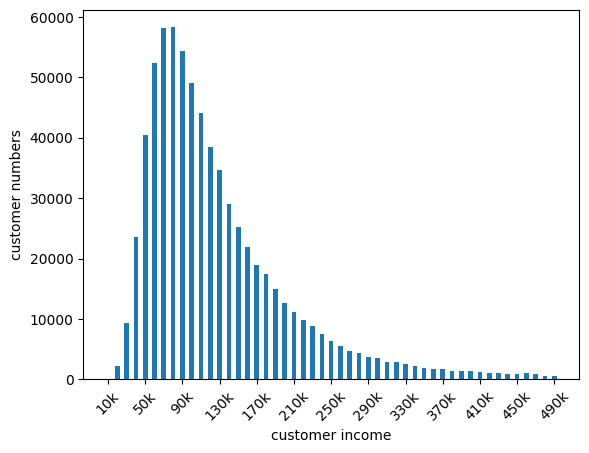

In [32]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(1)

x_data = [str(i.right//1000)+'k' for i in customer_income_dist.index ]
myLocator = mticker.MultipleLocator(4)
y_data = customer_income_dist.to_list()
plt.bar(x_data, y_data, align='center', width=0.5)
plt.xlabel('customer income')
plt.ylabel('customer numbers')
ax.xaxis.set_major_locator(myLocator)
#axis_label = ax.set_xticklabels(x, rotation= 30)
axis_label = plt.xticks(rotation=45)
